Git repo: https://bit.ly/3x1AFQ1

To follow along with the notes open Content.ipynb.

Why python?
===========

- Easy batch processing
- Easy to implement custom functions
- Access to deep learing tools and pretrained models

Overview
========
- Opening images in python
- Visualizing 2D images
- Histograms
- Cropping
- Thresholding and label images
- Binning and denoising
- Multi-channel images
- Visualizing nD images with napari
- Saving images from python

Opening images in python
========================
Many packages provide functions for loading images.
For common file formats you can use `scikit-image`.
If this don't work, you can look for specialized libraries.
Here is a non-exhaustive list of packes for specific formats:
* `tifffile`
* `mrcfile`
* `h5py`
* `hyperspy` for dm4 files
* `sims` for nanoSIMS data

Let's open our first image using `scikit-image`:

In [1]:
import skimage.io
img = skimage.io.imread("camera_2_img_000001.jpg")

Let's inspect the return value of this function...

In [2]:
type(img)

numpy.ndarray

The object returned is a numpy array. This is the most common way to represent images in python. Most libaries will return the image as a numpy array when you open it.

In [3]:
img.shape

(480, 960)

The shape attribute of the array tells us the size of the grid.
In this case, the image we loaded has a height of 480 pixels and a width of 960 pixels.

In [4]:
img.dtype

dtype('uint8')

The dtype attribute tells us what kind of numbers are saved in the image.

There are two main types in you should know about, integers (int) and floating point numbers (float). The latter are simply numbers with decimals.

Besides the type of the numbers, the dtype also has a number of bits associated with it, such as 8, 16, 32 or 64. This tells us how much memory we need to store one number.
Generally speaking, a larger number of bits means we can store larger number.

Most images are of type unsigned int 8-bit (uint8) or 16-bit (uint16).

Our image is of type uint8. This means the pixels can take values between 0 and 2^8 - 1 = 255.

Visulaizing 2D images
=====================

Next, we will have a look at the image we just loaded. For 2D images `matplotlib` is commonly used for visualization.

Let's start by importing the library. (The line before the import makes our plots interactive inside the jupyter notebook.)

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt

To display an image using matplotlib. Three basic steps are requires:

1. Create a new figure.
2. Add the image to the plot using imshow.
3. Display the figure with show. 

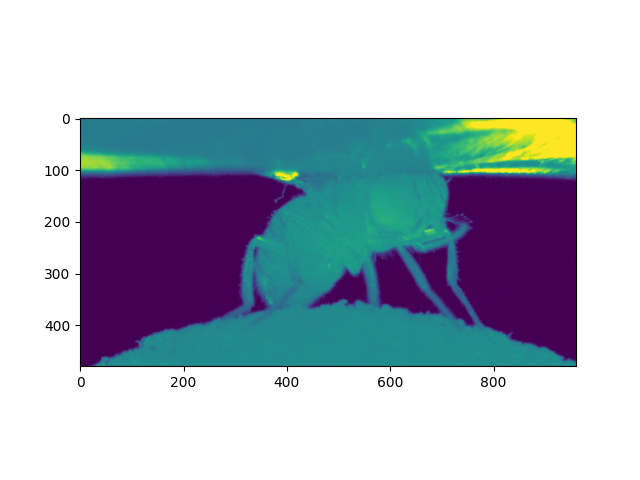

In [6]:
plt.figure()
plt.imshow(img)
plt.show()

The image is shown in false color using a color map, which maps low values to dark purple and high values to yellow. If you want to display the image in gray scale you can do so by adding `cmap="gray"` to imshow.

It can also be usefull to see the actual values of the pixels. You can do so by adding a `colorbar` to the plot.

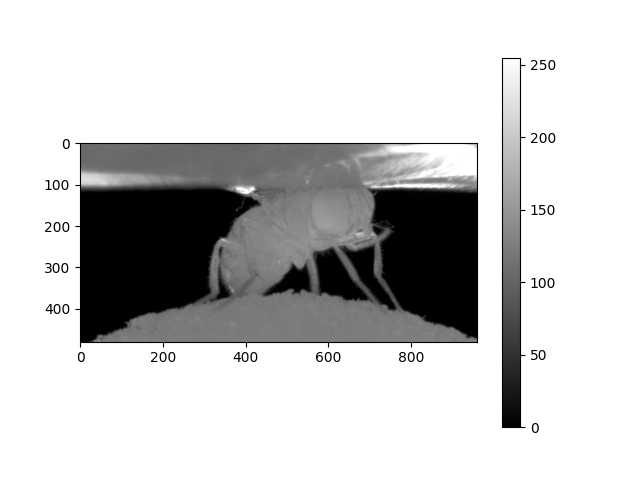

In [7]:
plt.figure()
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()

Histogram
=========

Another common way to look at the pixel values of an image is the histogram.
matplotlib provides us with the `hist` function to show a histogram.
If we pass it a 2D array, it will creat a histogram for each row encoding the row numbers by different colors. Since we want a single histogram for the entire image, we have to `flatten` the array. The `flatten` operation makes an nD array 1D. In our case that means all of the rows will be concatenated to form a 1D array.

You can also specify the number of bins and the possible range of values. This is especially usefull if your images does not contain all possible values.

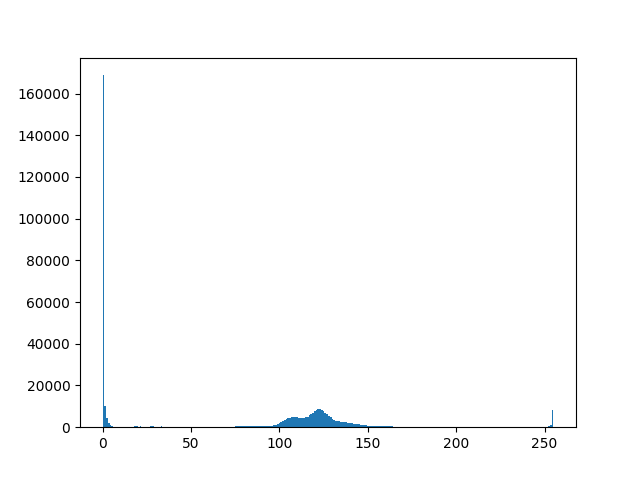

In [8]:
plt.figure()
plt.hist(img.flatten(), bins=256, range=(0, 255))
plt.show()

In the histogram we can seen that there are some very dark pixels (the black background behind the fly) and some very bright pixels (the reflection above the fly). Most of the remaining pixels, which include the subject, have values between 60 and 180.

To maximize the contrast of our subject we can set the minimum values `vmin` to 60 and the maximum value `vmax` to 180 when we show the images. This means that all values below 60 will be shown as black and all values above 180 will be shown as white.

Below you can see how we can make subplots and add color bars to them.
Note the `sharex` and `sharey` keyword arguments. They can be used to synchronize the zoom in an interactive plot.

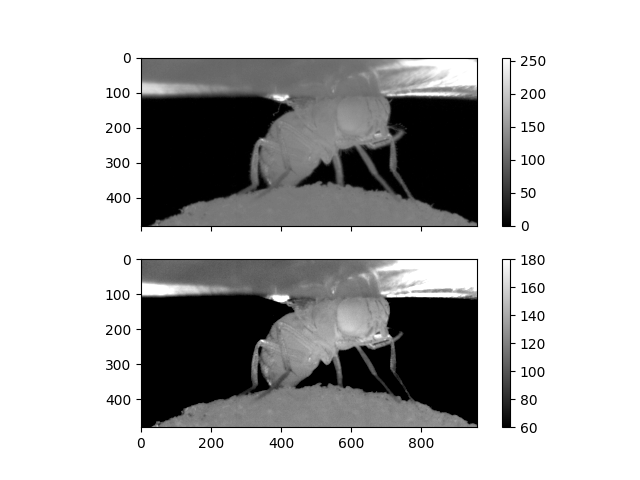

In [9]:
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True)
imgplot0 = axes[0].imshow(img, cmap="gray")
plt.colorbar(imgplot0, ax=axes[0])
imgplot1 = axes[1].imshow(img, cmap="gray", vmin=60, vmax=180)
plt.colorbar(imgplot1, ax=axes[1])
plt.show()

Cropping
========
Next we will learn how to crop an image. Notice in the plot above that the origin of the coordinate system is in the top left corner. This is a universaly accepted convention in image analysis.
We can crop the image by slice indexing the numpy array as follows:

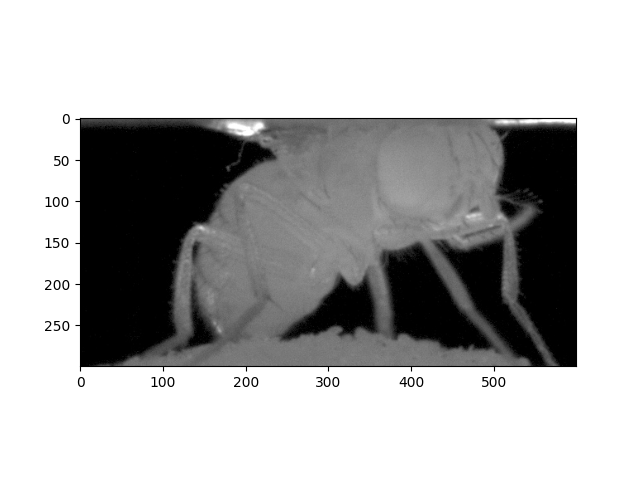

In [10]:
cropped = img[100:400, 200:800]
plt.figure()
plt.imshow(cropped, cmap="gray")
plt.show()

Thresholding and label images
=============================
Thresholding is the most naive approach for image segmentation.
However, if your images have very little noise and the imaging conditions are
consistent it can be useful.

Let's load a fluorescence image of some cells...

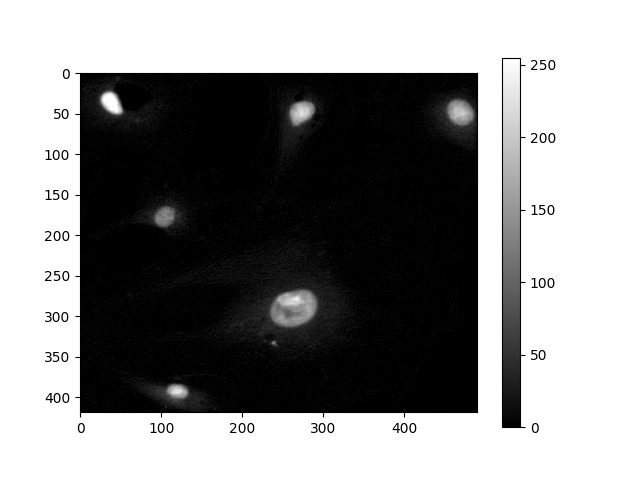

In [11]:
img = skimage.io.imread("C3-FluorescentCells.tif")
plt.figure()
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()

This image looks like it is well suited for thresholding. The background and the foreground are well seperated by many gray levels.
Instead of eyeballing the right value for the threshold we can use Otsu's method.
Otsu's method returns the value that minimizes intra-class variance.

Once we have the threshold value we can threshold the image using the "larger than" operator `>`. This returns a numpy array of `dtype` bool, which is `False` for all pixels with values smaller or equal to our threshold and `True` everywhere else.

When we display the image with matplotlib, `False` is interpreted as 0 and `True` as 1.

75


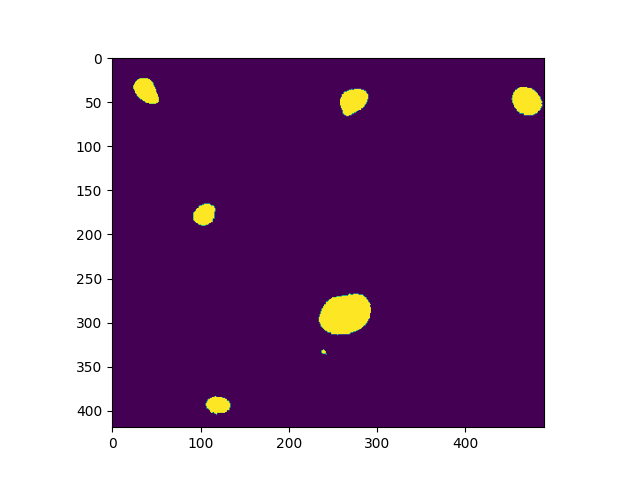

In [12]:
thresh = skimage.filters.threshold_otsu(img)
print(thresh)
binary = img > thresh
plt.figure()
plt.imshow(binary)
plt.show()

Next we will have to separate the binary image into individual instances.
This is commonly refered to as connected component anaylsis. In `scikit-image` we can find the necessary function under `skimage.measure.label`.
This function returns an array/image of integer values, where pixels belonging to different connected components will have different integer values.

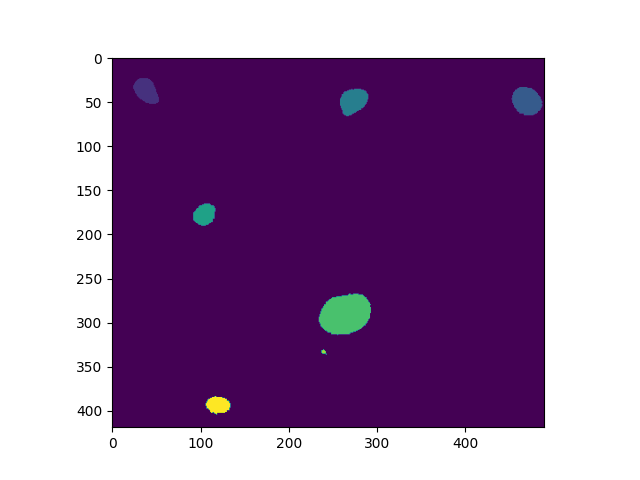

In [13]:
label_img = skimage.measure.label(binary)
plt.figure()
plt.imshow(label_img)
plt.show()

To select a single cell we can use the comparison operator `==`.
We will call the result a mask, because it is an array of `dtype` bool that can be used to index the array as we will see soon.

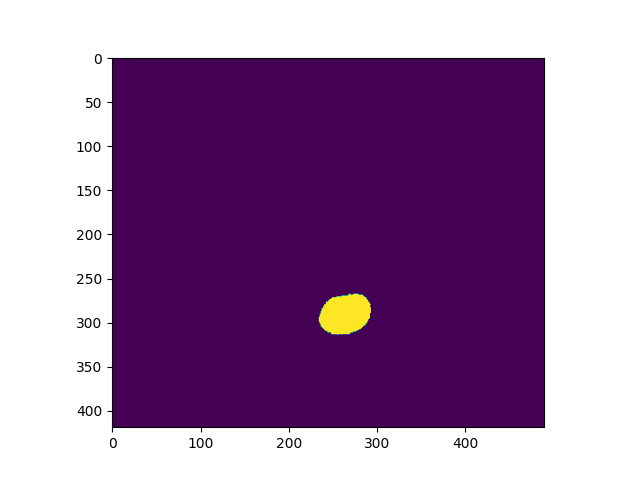

In [14]:
mask = (label_img == 5)
plt.figure()
plt.imshow(mask)
plt.show()

Since `True` is interpreted as 1 and `False` is interpreted as 0, we can simple sum up all of the value of the mask to get the size of the cell in terms of pixels.

In [15]:
import numpy as np
for i in range(1, label_img.max()):
    size = np.sum(label_img == i)
    print(f"Cell {i} is {size} pixels large.")

Cell 1 is 600 pixels large.
Cell 2 is 847 pixels large.
Cell 3 is 724 pixels large.
Cell 4 is 479 pixels large.
Cell 5 is 2136 pixels large.
Cell 6 is 20 pixels large.


Besides being able to sum the values, we can also use the mask for boolean indexing to get all of the pixel values of a given cell.
This works as follows:

In [18]:
mask = (label_img == 6)
pixel_values_of_cell_6 = img[mask]
pixel_values_of_cell_6.shape

(20,)

We can use this concept to calculate the average fluorescence of each cell.

In [19]:
for i in range(1, label_img.max()):
    avg_fluo = img[label_img == i].mean()
    print(f"Cell {i} has an average fluorescence of {avg_fluo}.")

Cell 1 has an average fluorescence of 201.16333333333333.
Cell 2 has an average fluorescence of 142.82408500590319.
Cell 3 has an average fluorescence of 154.24309392265192.
Cell 4 has an average fluorescence of 111.56367432150313.
Cell 5 has an average fluorescence of 138.85486891385767.
Cell 6 has an average fluorescence of 101.8.


Binning and denoising
=====================

Let's start by adding some noise to our images and displaying the images.

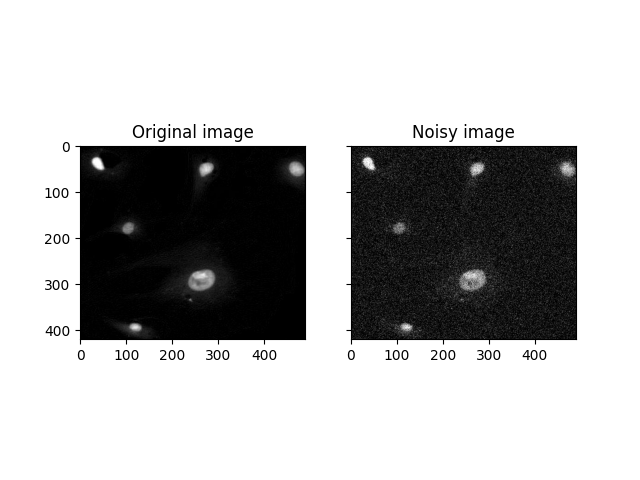

In [21]:
noisy_img = img + np.random.normal(loc=0, scale=50, size=img.shape)
noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
axes[0].imshow(img, cmap="gray", vmin=0, vmax=255)
axes[0].set_title("Original image")
axes[1].imshow(noisy_img, cmap="gray", vmin=0, vmax=255)
axes[1].set_title("Noisy image")
plt.show()

If you can sacrifice some spatial resolution, binning can be a good approach to reduce noise. Binning refers to grouping pixels together and averaging their values to form one single new pixel in the denoised image.

In [22]:
print(noisy_img.shape)
noisy_img_binned = skimage.transform.downscale_local_mean(noisy_img, 4)
print(noisy_img_binned.shape)

(419, 490)
(105, 123)


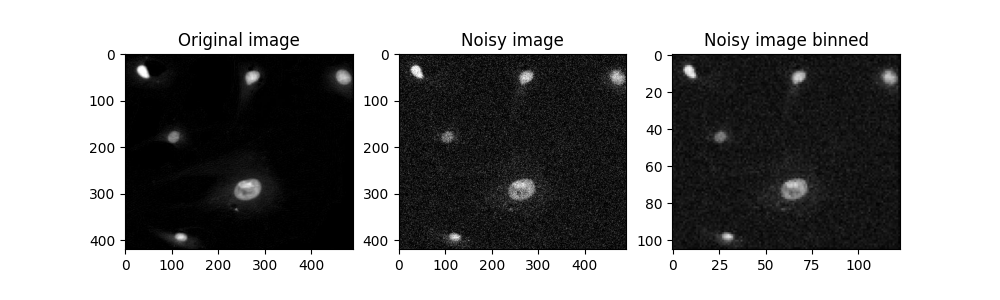

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].imshow(img, cmap="gray", vmin=0, vmax=255)
axes[0].set_title("Original image")
axes[1].imshow(noisy_img, cmap="gray", vmin=0, vmax=255)
axes[1].set_title("Noisy image")
axes[2].imshow(noisy_img_binned, cmap="gray", vmin=0, vmax=255)
axes[2].set_title("Noisy image binned")
plt.show()

Another relatively straight forward approach to denoising is median filtering.

In [26]:
import scipy.ndimage
print(noisy_img.shape)
noisy_img_median = scipy.ndimage.median_filter(noisy_img, 10)
print(noisy_img_median.shape)

(419, 490)
(419, 490)


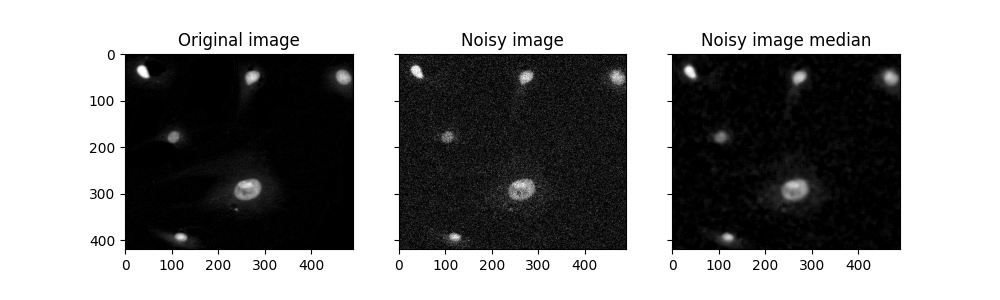

In [27]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 3))
axes[0].imshow(img, cmap="gray", vmin=0, vmax=255)
axes[0].set_title("Original image")
axes[1].imshow(noisy_img, cmap="gray", vmin=0, vmax=255)
axes[1].set_title("Noisy image")
axes[2].imshow(noisy_img_median, cmap="gray", vmin=0, vmax=255)
axes[2].set_title("Noisy image median")
plt.show()

Multi-channel images
====================

Sofar we have only looked at gray scale images. Next, we will take a look at color images, i.e. images with multiple channels.

We will start by loading and plotting an RGB image.

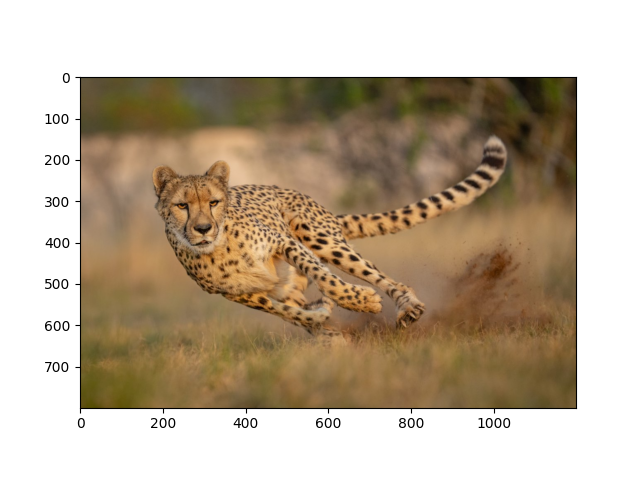

In [28]:
img = skimage.io.imread("cheetah-running.jpg")
plt.figure()
plt.imshow(img)
plt.show()

Matplotlib seems to understand that we are dealing with a color image, but how does the numpy array store the color?
Let's look at its shape to find out.

In [30]:
img.shape

(800, 1200, 3)

The red, green and blue channel of the RGB image are simple represented in an additional axis. If we only want to see the red values, we can do simply specify and index for the last dimension as follows:

In [29]:
red_channel = img[:, :, 0]
red_channel.shape

(800, 1200)

Visualizing nD images with napari
=================================

Napari is a python image viewer designed for n dimensional images.

First, lets load a large confocal microcopy volume with 3 channels.

In [30]:
stack = skimage.io.imread("OtdFlp_TubGal80_NGFP_stained_20X_brain.lsm")
print(stack.shape)

(148, 1024, 1024, 3)


To show the image using napari we first have to create a viewer.

In [31]:
import napari
viewer = napari.Viewer()

Then we can add the image to the viewer. Since I don't want napari to interprete my image as RGB, I need to explicitely tell what the channel axis is and what colors to use.

In [34]:
viewer.add_image(stack, channel_axis=3, colormap=["green", "blue", "magenta"])

[<Image layer 'Image [3]' at 0x76b874123910>,
 <Image layer 'Image [4]' at 0x76b8741512a0>,
 <Image layer 'Image [5]' at 0x76b86e75f9a0>]

In [ ]:
You might notice the image we are looking at is upside down. To flip it, we can use a convenient numpy indexing trick.

In [36]:
stack = stack[:, ::-1]
viewer.add_image(stack, channel_axis=3, colormap=["green", "blue", "magenta"])

[<Image layer 'Image [9]' at 0x76b86ca0edd0>,
 <Image layer 'Image [10]' at 0x76b86ca0fb50>,
 <Image layer 'Image [11]' at 0x76b85ff6e9e0>]

Next, we will generate a maximum intensity projection.

In [37]:
max_intensity_projection = np.max(stack, axis=0)
print(max_intensity_projection.shape)
viewer.add_image(max_intensity_projection, channel_axis=2, colormap=["green", "blue", "magenta"])

(1024, 1024, 3)


[<Image layer 'Image [12]' at 0x76b86ca0f730>,
 <Image layer 'Image [13]' at 0x76b87c1e9d20>,
 <Image layer 'Image [14]' at 0x76b8535a62c0>]

How to make your data isotropic
===============================

Especially in microscopy, volumes are often anisotropic. If we knot the voxel size of our data, we can fix this problem using `scipy.ndimage.zoom`. To speed-up the computation we will only apply this corrections to a crop of the stack of the first channel.

In [41]:
substack = stack[:, 256:768, 256:768, 0]
print(substack.shape)

import scipy.ndimage
voxel_size = np.array([0.831, 0.527, 0.527])

iso_substack = scipy.ndimage.zoom(substack, (voxel_size[0] / voxel_size[1], 1, 1), order=1)
iso_substack.shape

(148, 512, 512)


(233, 512, 512)

We can see what happened in napari's volume viewer...

In [42]:
viewer.add_image(substack)
viewer.add_image(iso_substack)

<Image layer 'iso_substack' at 0x76b86cfc9030>

Saving images from python
=========================
To save 2D images you can use `skimage.io.imwrite`. Make sure you choose a format with lossless or no compression, such as png or tif if you plan to use the images for any further anlysis.

Here, we will focus on the writing multi-channel tif files that display correctly in Fiji.
To do this we will use a library called `tifffile`.

The first thing we need to do to our stack is reorder the axis, because Fiji likes ZCYX axis order and our stack is ZYXC, where C is the color channel axis.

We can do this using the numpy's rollaxis function.

In [43]:
import numpy as np
print(stack.shape)
stack = np.rollaxis(stack, 3, 1)
print(stack.shape)

(148, 1024, 1024, 3)
(148, 3, 1024, 1024)


In [45]:
import tifffile
tifffile.imwrite("testwrite.tif", stack, imagej=True, metadata={"axes": "ZCYX"})

To make things a bit more convenient, we can also specify the display mode and the colors.

In [26]:
green_lut = np.zeros((3, 256), dtype=np.uint8)
green_lut[1] = np.arange(256)
blue_lut = np.zeros((3, 256), dtype=np.uint8)
blue_lut[2] = np.arange(256)
mangenta_lut = np.zeros((3, 256), dtype=np.uint8)
mangenta_lut[0] = np.arange(256)
mangenta_lut[2] = np.arange(256)
tifffile.imwrite("testwrite.tif", stack, imagej=True, metadata={"axes": "ZCYX", "mode": "composite", "LUTs": [green_lut, blue_lut, mangenta_lut]})

Beyond numpy
============
- pytorch / tensorflow can be used for computations on the GPU and differentiation (instead of `numpy.array` we use `torch.Tensor` or `tensorflow.Tensor`)
- dask can be used for datasets that are too big to fit in memory (instead of `numpy.array` we use `dask.array`)

In [3]:
import dask
img = dask.array.image.imread("tifs/*.tif")
img.shape

In [ ]:
img.dtype

In [ ]:
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return f"{s:.2f} {size_name[i]}"
    
convert_size(img.size * 2)